In [ ]:
# Устанавливаем библиотеку catboost
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.4 MB/s eta 0:00:00


In [ ]:
# Устанавливаем необходимые библиотеки для анализа данных, визуализации, машинного обучения
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
import joblib
from tensorflow import keras
from math import sqrt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor

In [ ]:
# Формируем названия признаков и считываем данные
index_names = ["Двигатель", "Цикл"]
setting_names = [f"Условие_{i}" for i in range(1, 4)]
sensor_names = [f"Датчик_{i}" for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names
col_rul = ["Остаточный ресурс"]
train_data = pd.read_csv(r"/content/train_FD001.txt", sep="\s+", names=col_names)
test_data = pd.read_csv(r"/content/test_FD001.txt", sep="\s+", names=col_names)
rul_data = pd.read_csv(r"/content/RUL_FD001.txt", sep="\s+", names=col_rul)

In [ ]:
# Просматриваем первые несколько строк обучающих данных
train_data.head()

,Двигатель,Цикл,Условие_1,Условие_2,Условие_3,Датчик_1,Датчик_2,Датчик_3,Датчик_4,Датчик_5,...,Датчик_12,Датчик_13,Датчик_14,Датчик_15,Датчик_16,Датчик_17,Датчик_18,Датчик_19,Датчик_20,Датчик_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
# Получаем сводку об обучающих данных
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Двигатель  20631 non-null  int64  
 1   Цикл       20631 non-null  int64  
 2   Условие_1  20631 non-null  float64
 3   Условие_2  20631 non-null  float64
 4   Условие_3  20631 non-null  float64
 5   Датчик_1   20631 non-null  float64
 6   Датчик_2   20631 non-null  float64
 7   Датчик_3   20631 non-null  float64
 8   Датчик_4   20631 non-null  float64
 9   Датчик_5   20631 non-null  float64
 10  Датчик_6   20631 non-null  float64
 11  Датчик_7   20631 non-null  float64
 12  Датчик_8   20631 non-null  float64
 13  Датчик_9   20631 non-null  float64
 14  Датчик_10  20631 non-null  float64
 15  Датчик_11  20631 non-null  float64
 16  Датчик_12  20631 non-null  float64
 17  Датчик_13  20631 non-null  float64
 18  Датчик_14  20631 non-null  float64
 19  Датчик_15  20631 non-null  float64
 20  Датчик

In [ ]:
# Получаем описательную статистику по обучающим данным
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Двигатель,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
Цикл,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
Условие_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
Условие_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
Условие_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
Датчик_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
Датчик_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
Датчик_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
Датчик_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
Датчик_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200


In [ ]:
# Считаем количество пропущенных значений по каждому признаку
train_data.isnull().sum()

Двигатель    0
Цикл         0
Условие_1    0
Условие_2    0
Условие_3    0
Датчик_1     0
Датчик_2     0
Датчик_3     0
Датчик_4     0
Датчик_5     0
Датчик_6     0
Датчик_7     0
Датчик_8     0
Датчик_9     0
Датчик_10    0
Датчик_11    0
Датчик_12    0
Датчик_13    0
Датчик_14    0
Датчик_15    0
Датчик_16    0
Датчик_17    0
Датчик_18    0
Датчик_19    0
Датчик_20    0
Датчик_21    0
dtype: int64

In [ ]:
# Находим для каждого авиадвигателя из обучающих данных максимальное значение остаточного ресурса
pre_data = train_data.copy(deep=True)
train_data_rul = pre_data.groupby(["Двигатель"])["Цикл"].max().reset_index()
train_data_rul.columns = ["Двигатель", "Максимальный остаточный ресурс"]
train_data_rul.head()

,Двигатель,Максимальный остаточный ресурс
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


In [ ]:
# Вычисляем значение остаточного ресурса на каждом полетном цикле для каждого авиадвигателя
pre_data = pre_data.merge(train_data_rul, how="left", on="Двигатель")
pre_data["Остаточный ресурс"] = pre_data["Максимальный остаточный ресурс"] - pre_data["Цикл"]
pre_data.drop(columns=["Максимальный остаточный ресурс"], inplace=True)

In [ ]:
# Просматриваем первые несколько строк обучающих данных
pre_data.head()

,Двигатель,Цикл,Условие_1,Условие_2,Условие_3,Датчик_1,Датчик_2,Датчик_3,Датчик_4,Датчик_5,...,Датчик_13,Датчик_14,Датчик_15,Датчик_16,Датчик_17,Датчик_18,Датчик_19,Датчик_20,Датчик_21,Остаточный ресурс
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


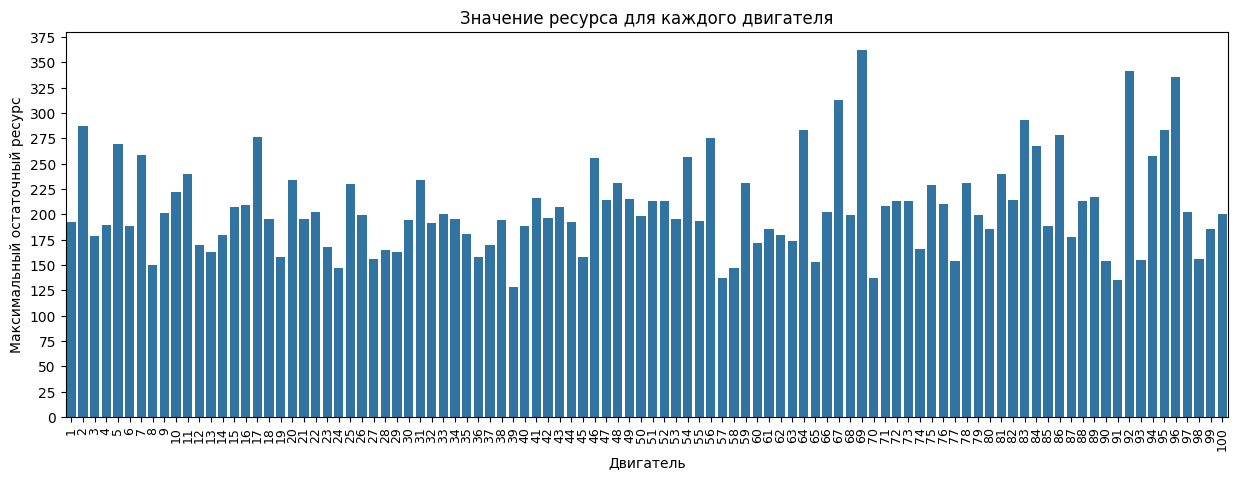

In [ ]:
# Строим столбчатую диаграмму, которая показывает максимальное значение остаточного ресурса для каждого авиадвигателя
plt.figure(figsize=(15, 5))
sns.barplot(train_data_rul, x="Двигатель", y="Максимальный остаточный ресурс")
plt.yticks(range(0, 376, 25))
plt.title("Значение ресурса для каждого двигателя")
plt.xticks(size=9, rotation=90)
plt.show()

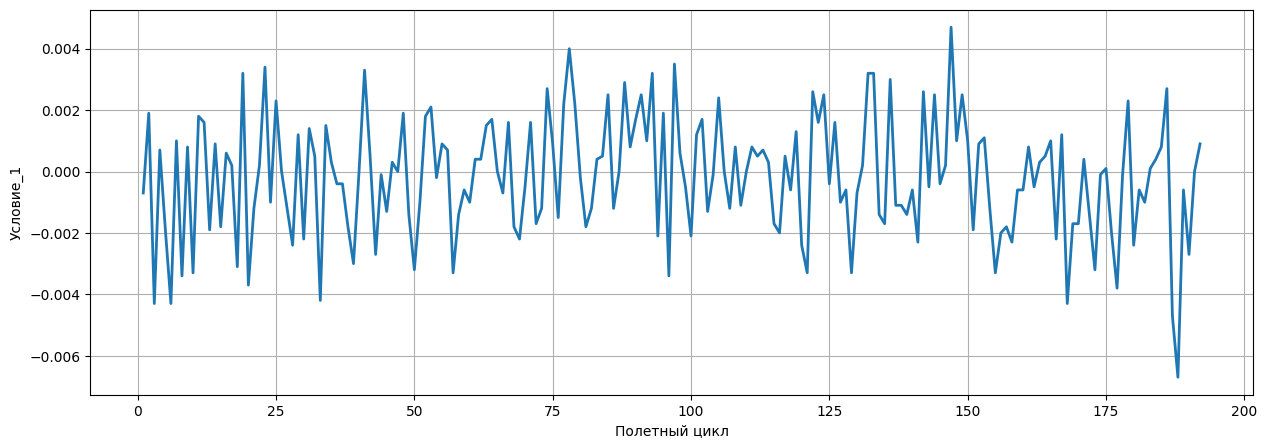

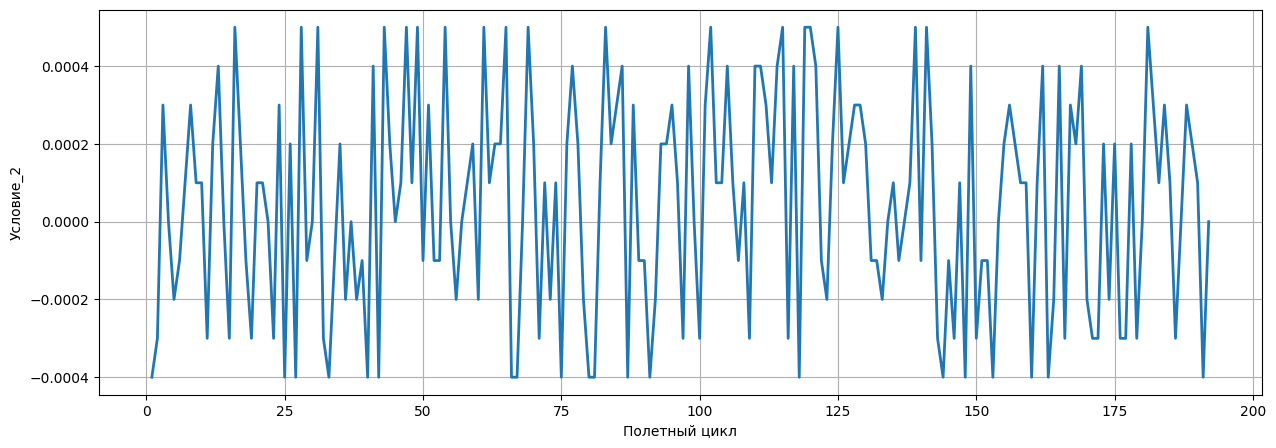

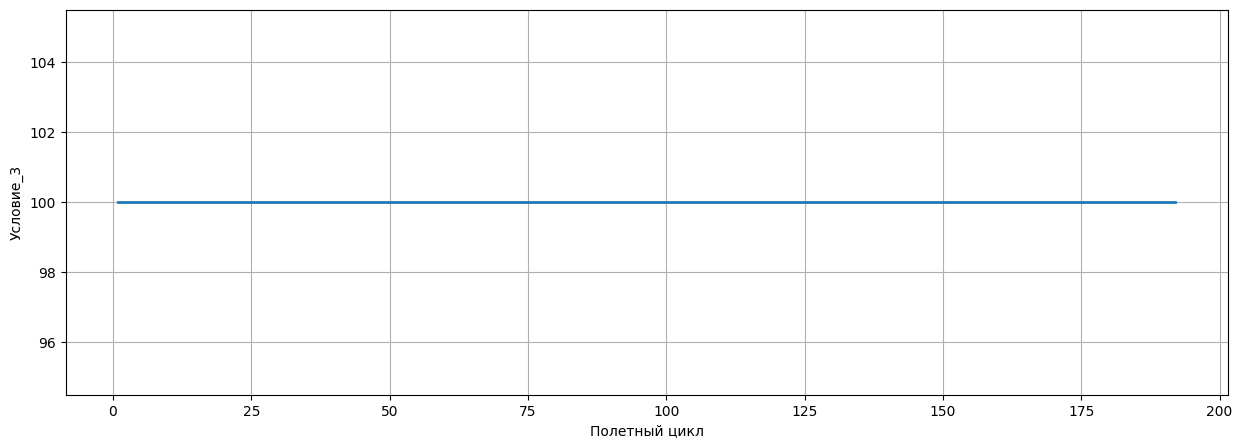

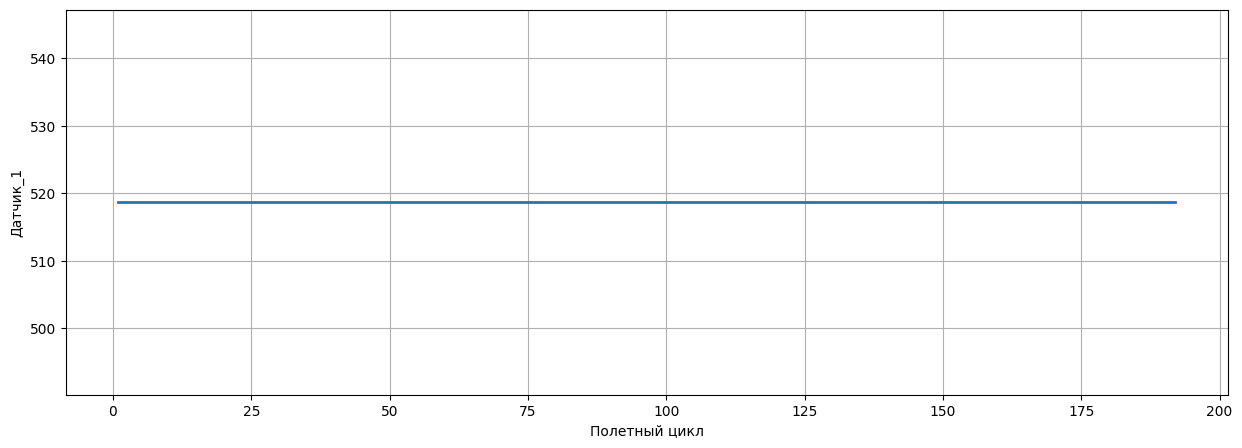

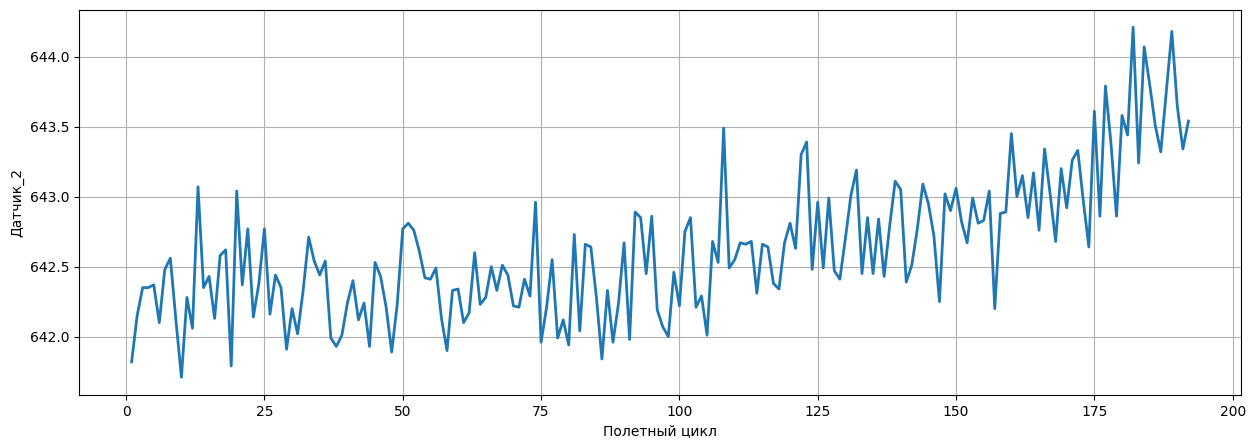

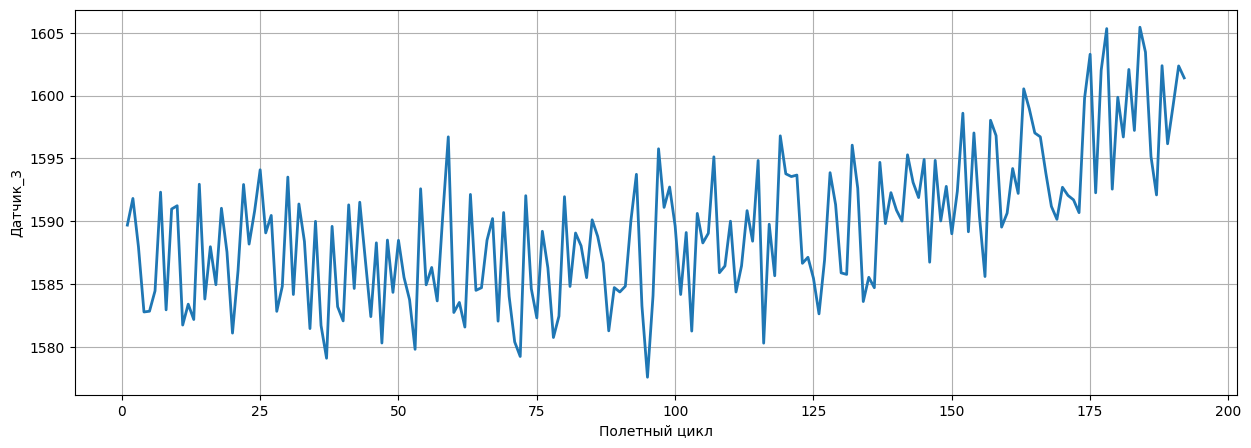

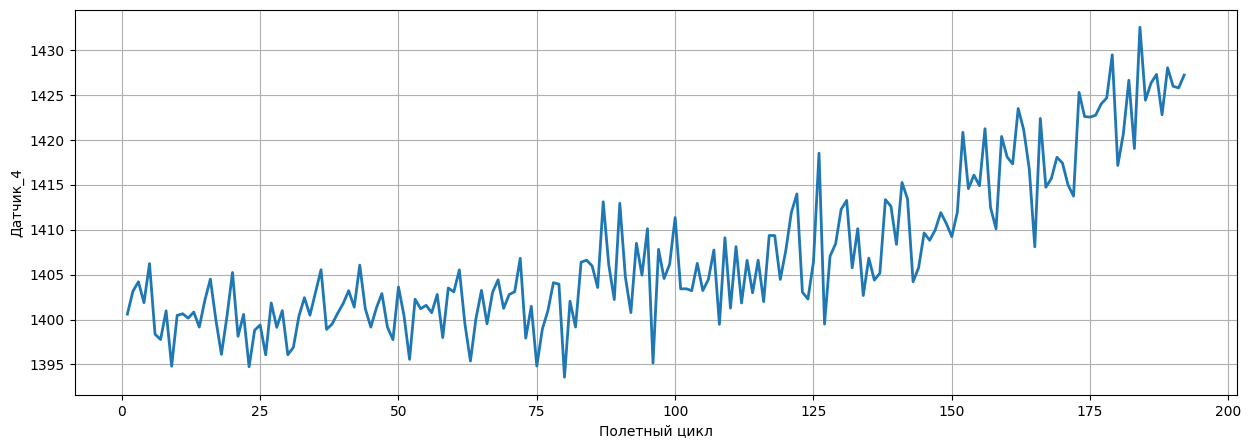

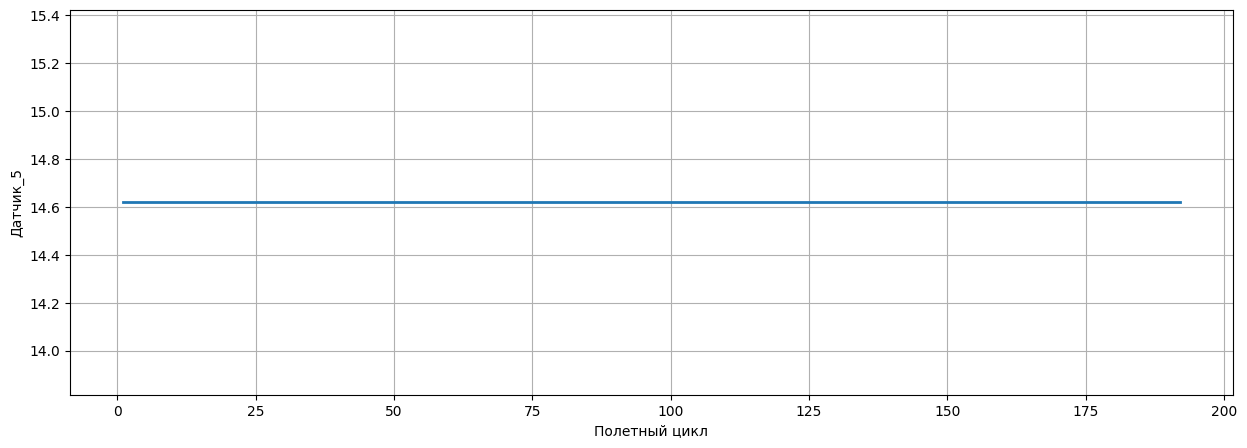

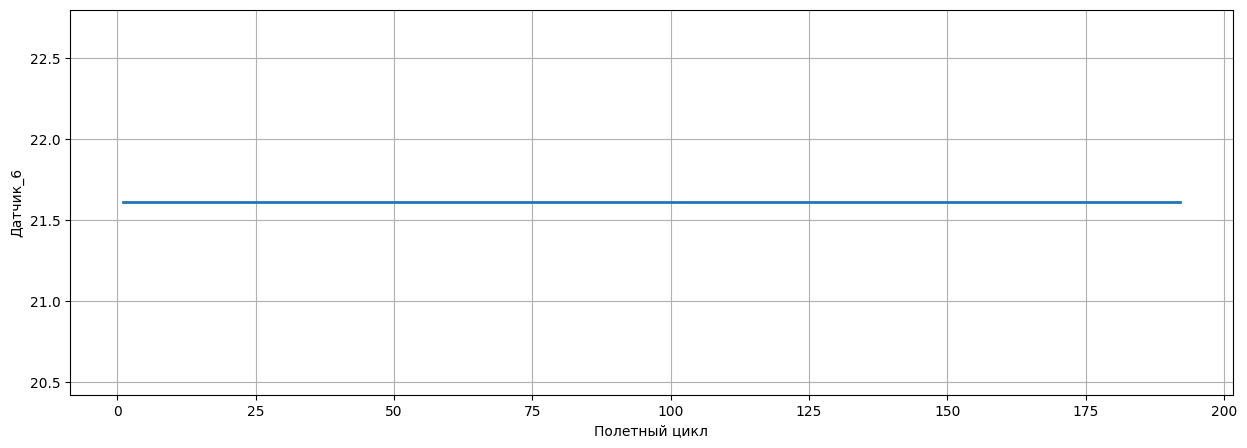

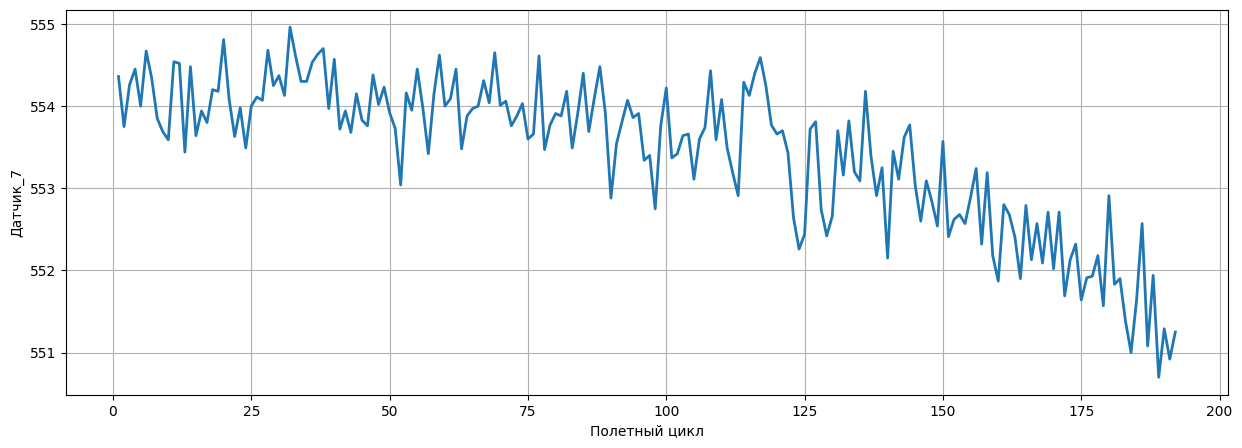

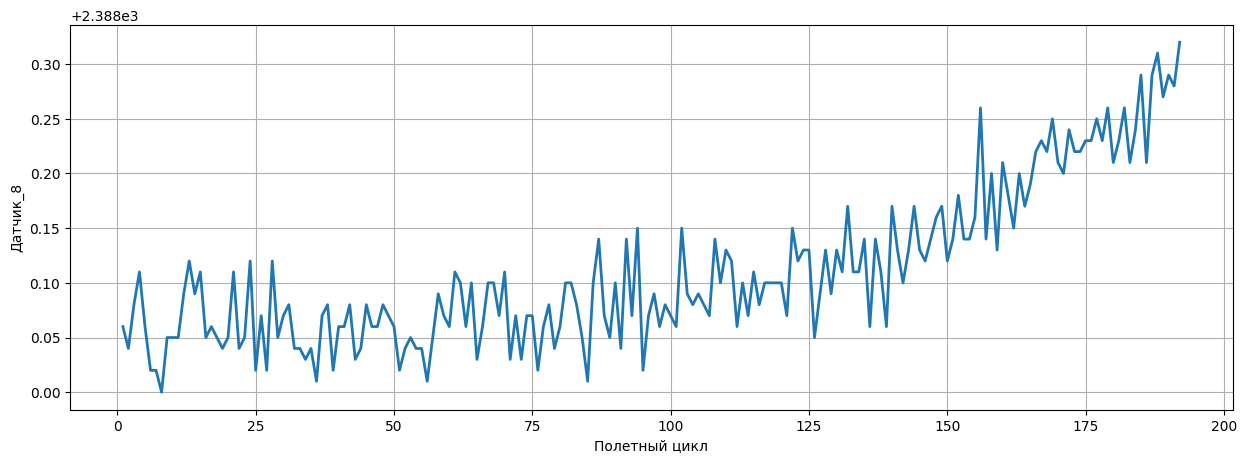

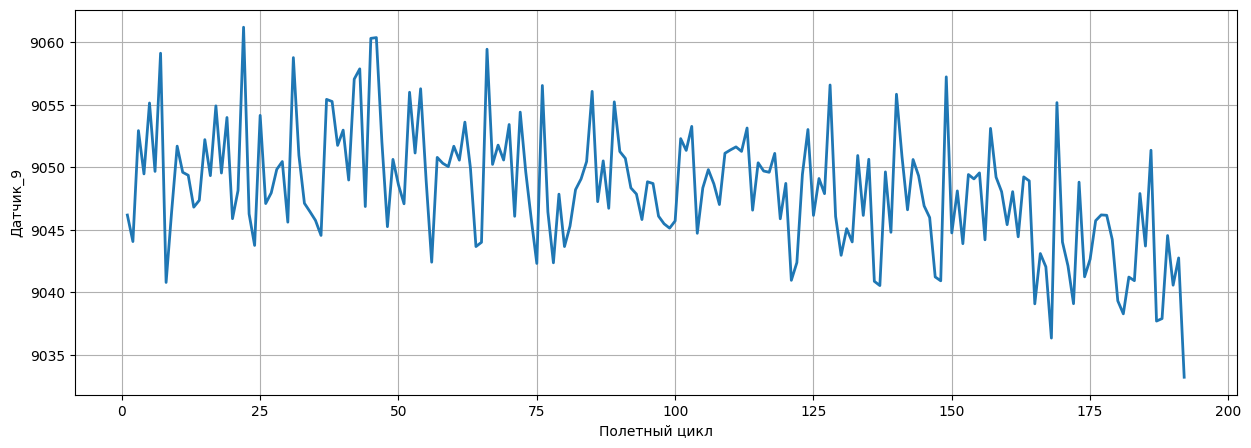

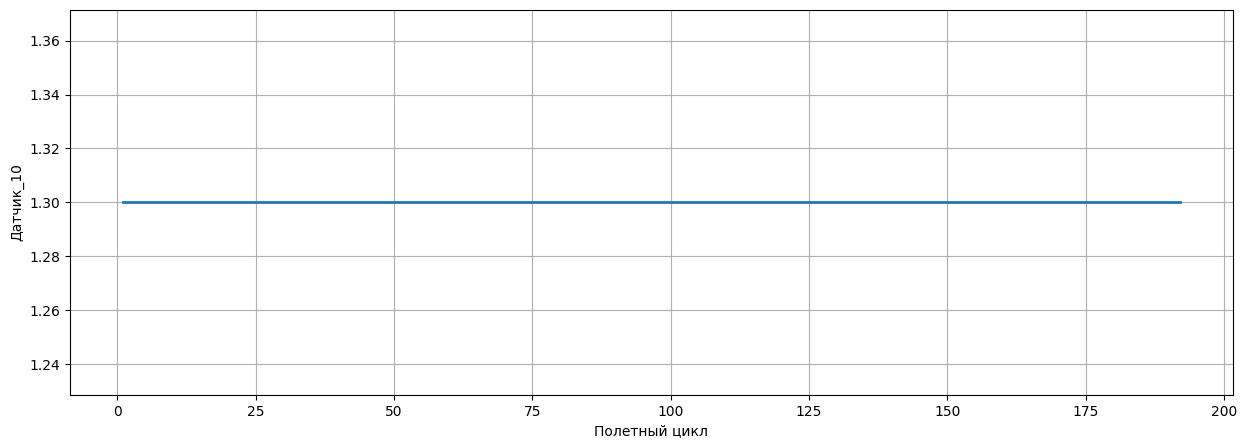

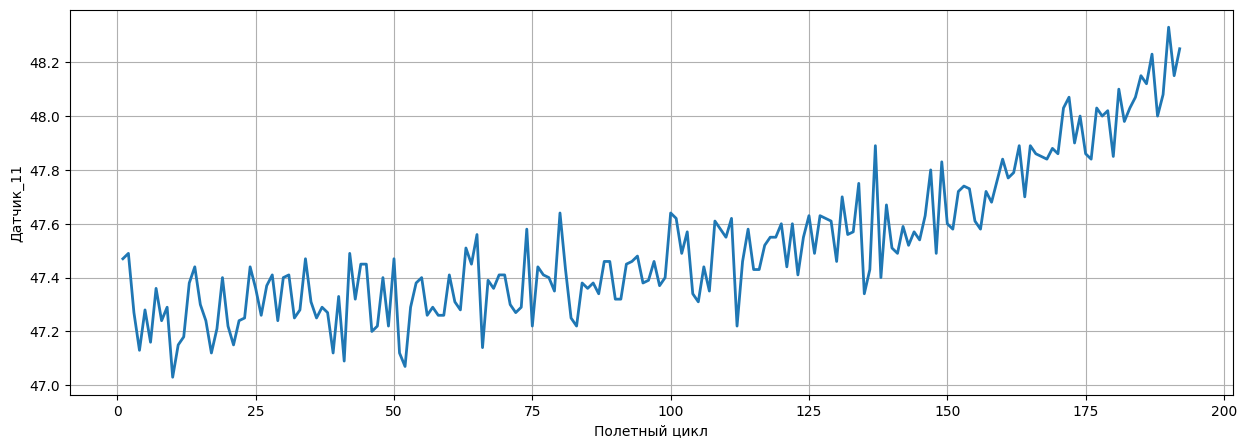

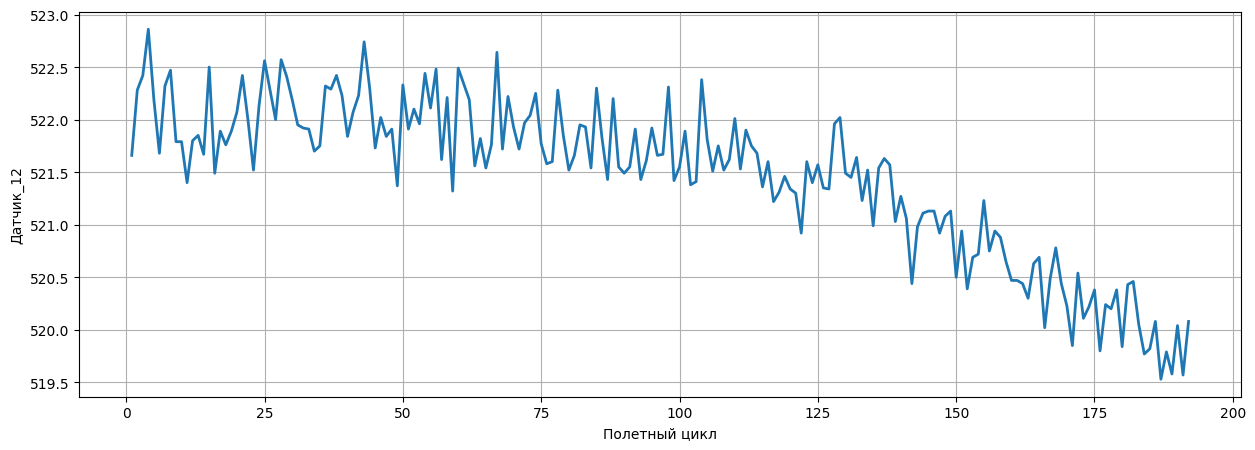

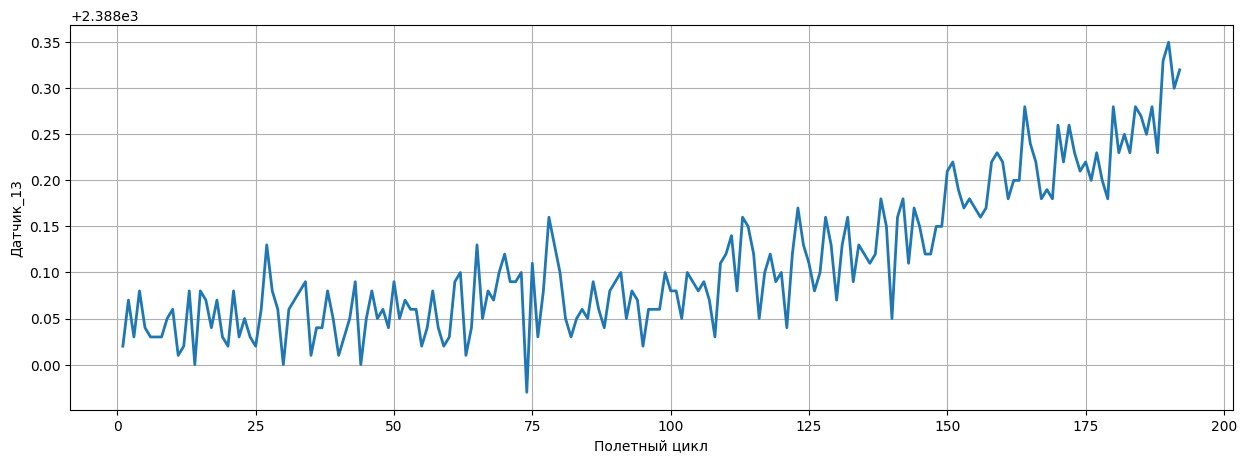

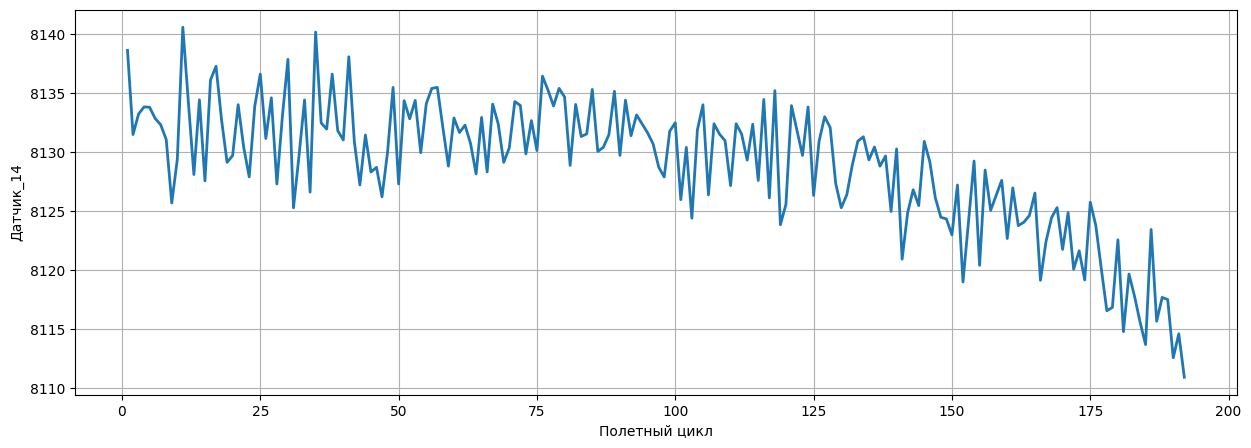

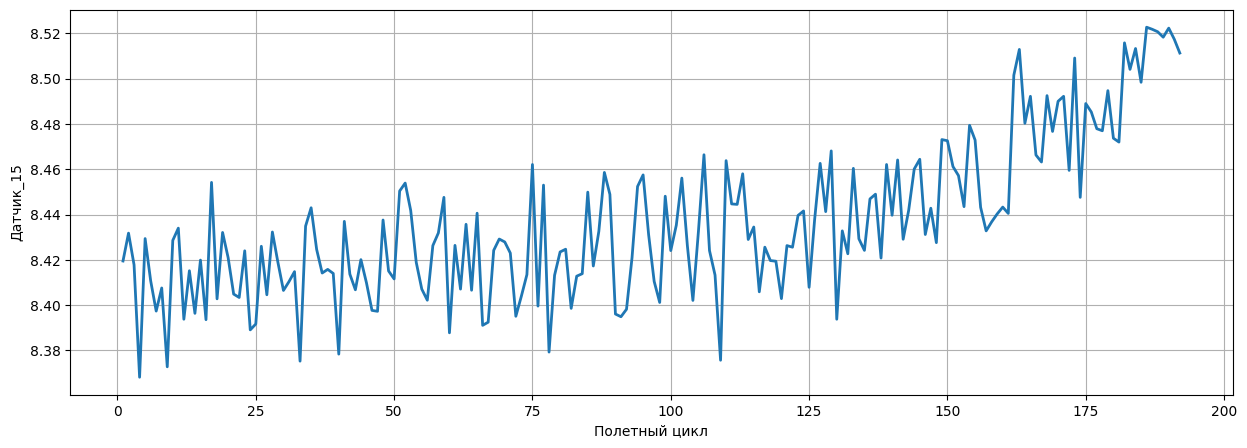

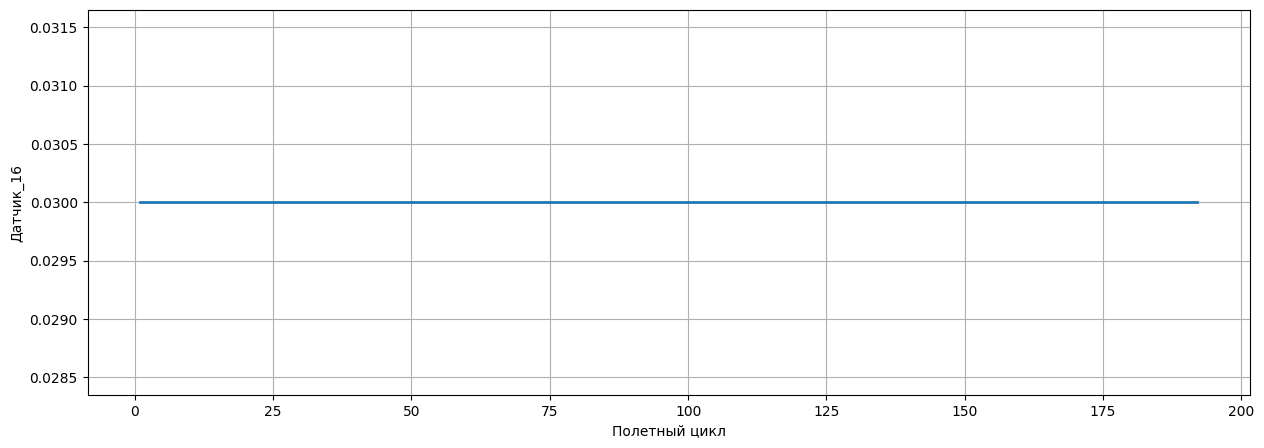

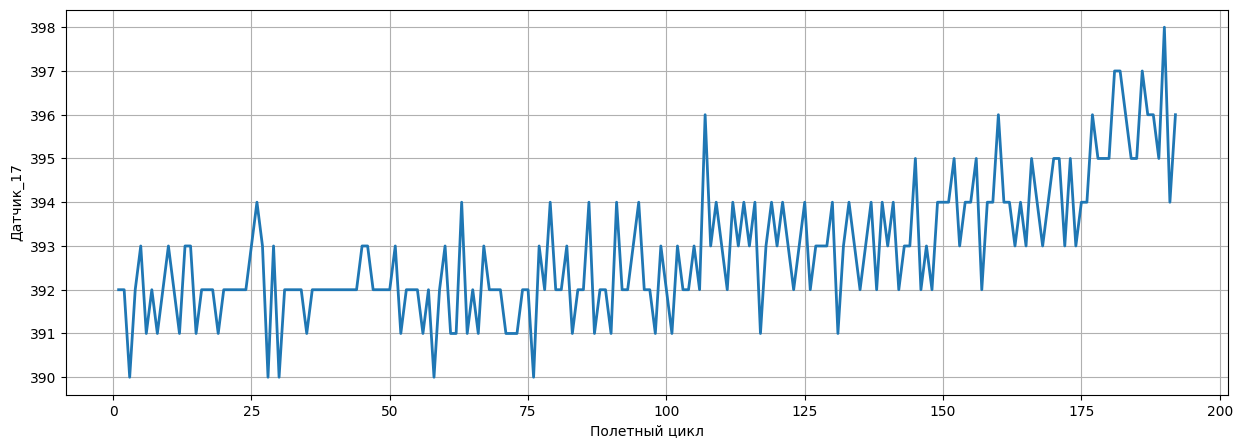

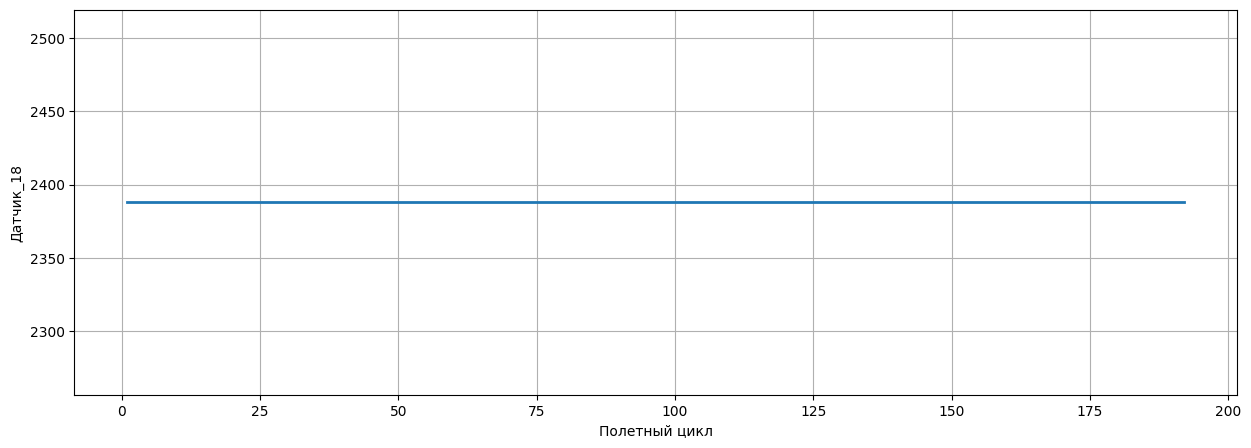

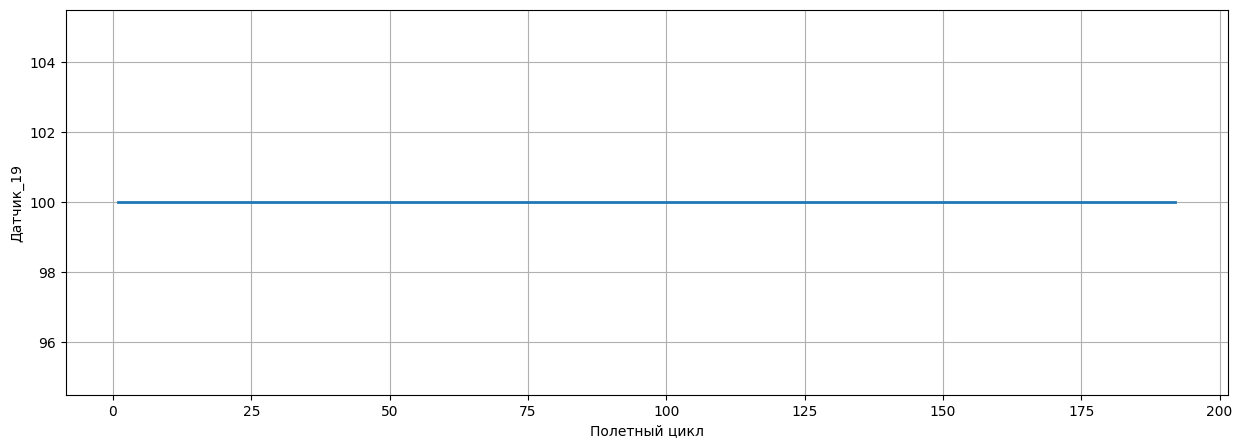

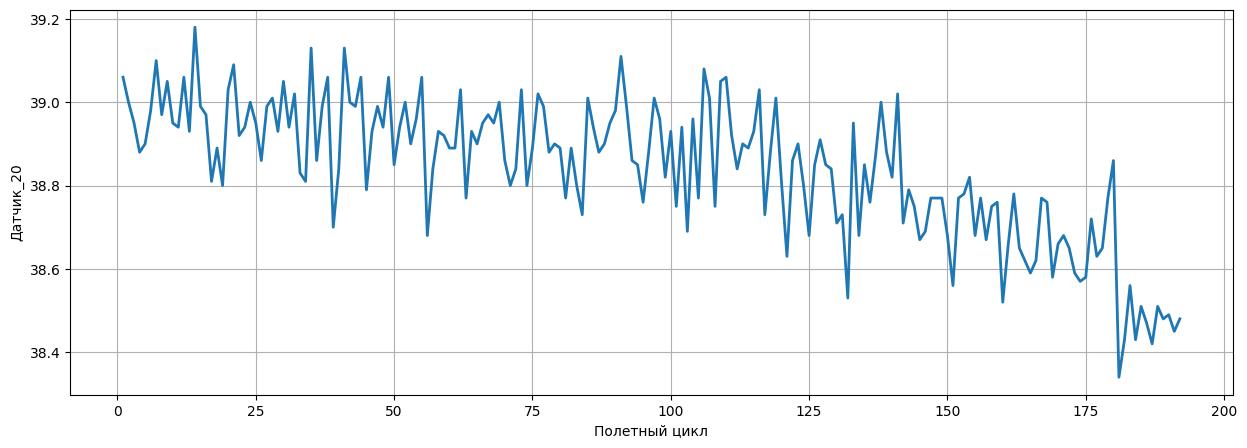

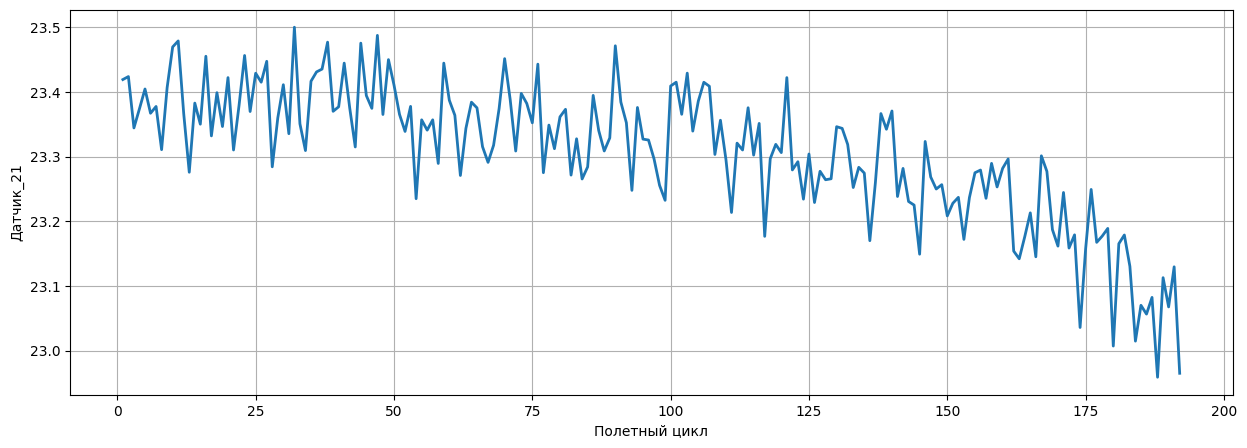

In [ ]:
# Строим линейные графики изменения значений датчиков с увеличением наработки
x = pre_data[(pre_data["Двигатель"]==1)]["Цикл"]
df = pre_data[(pre_data["Двигатель"]==1)].iloc[:, 2:26]
for column in df:
  plt.figure(figsize=(15, 5))
  y = df[column]
  plt.plot(x, y, linewidth=2)
  plt.xlabel("Полетный цикл")
  plt.ylabel(column)
  plt.grid(True)
  plt.show()

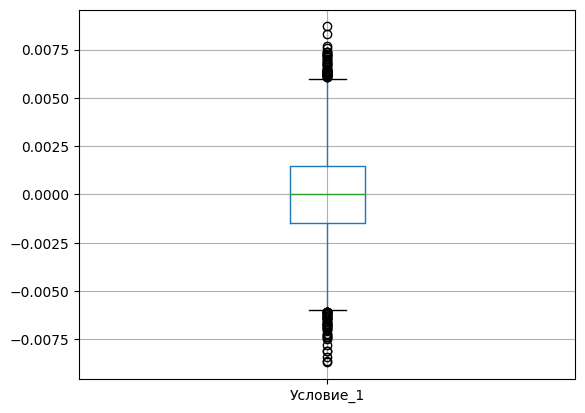

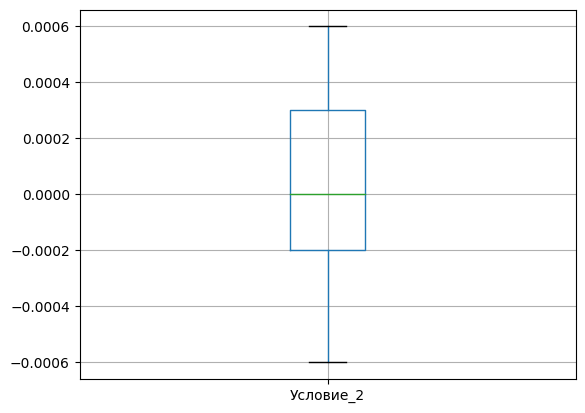

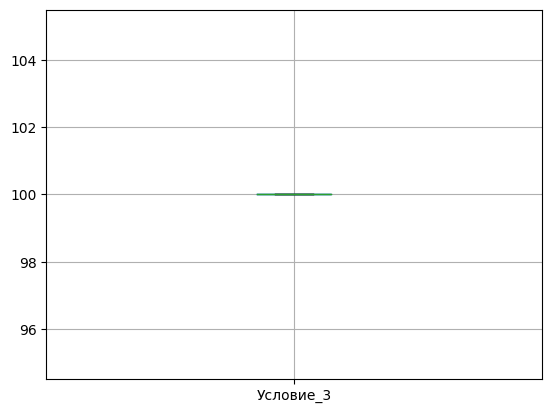

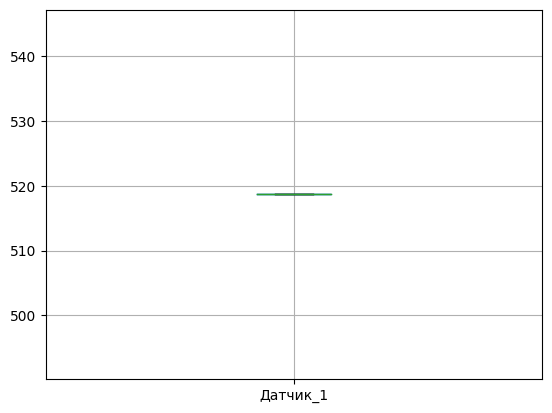

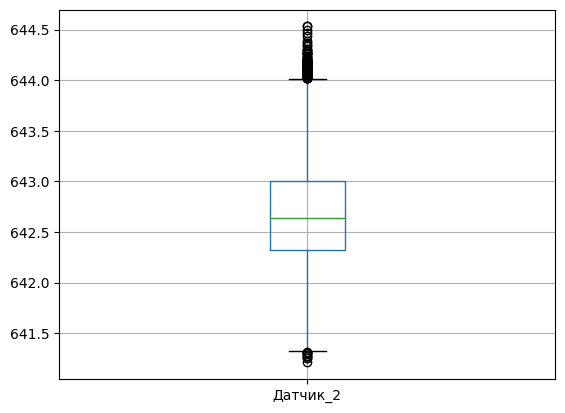

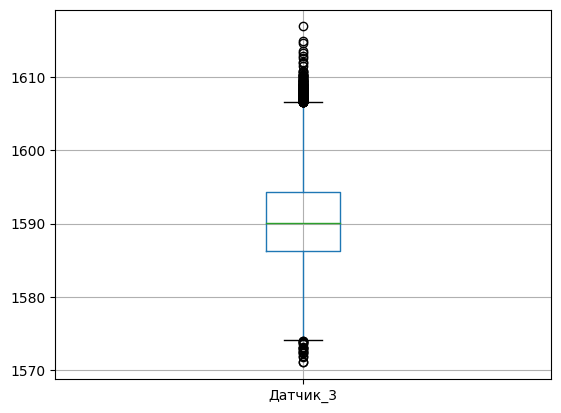

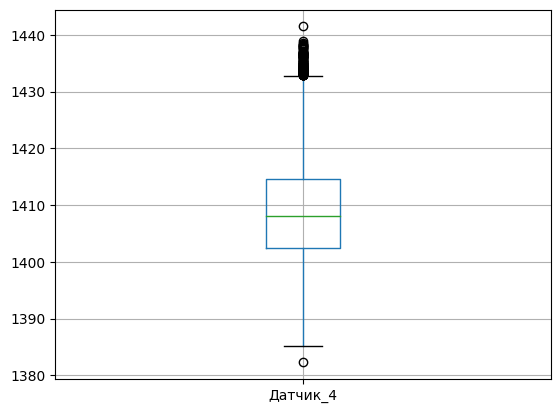

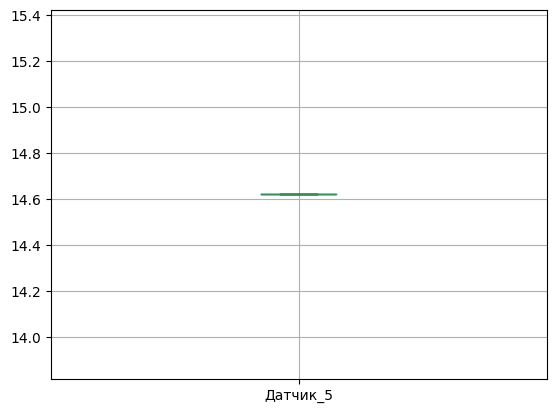

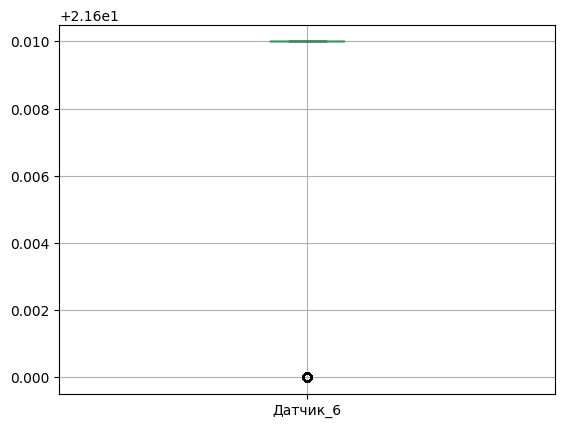

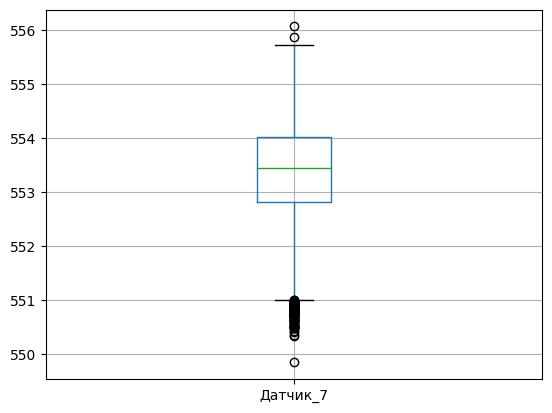

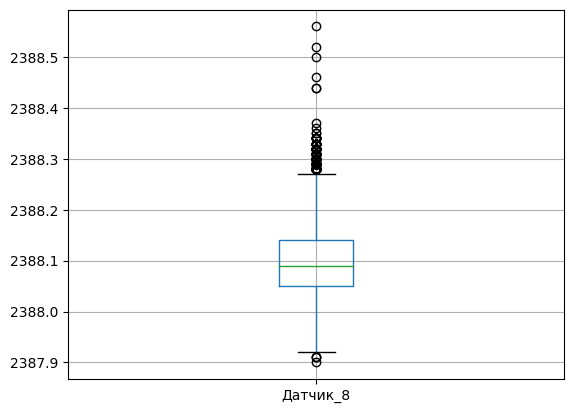

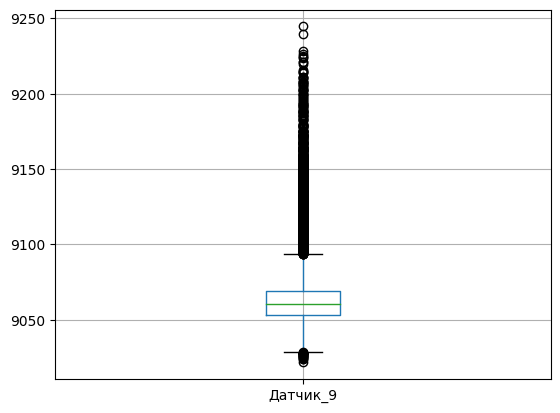

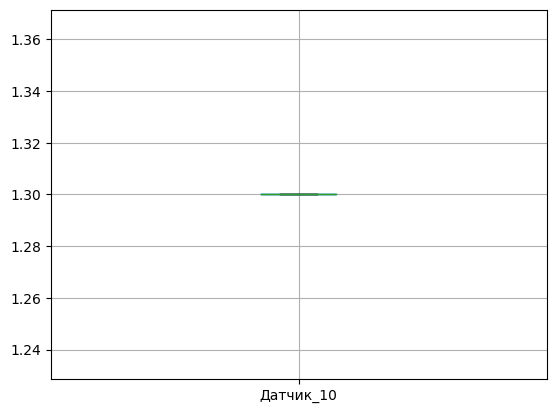

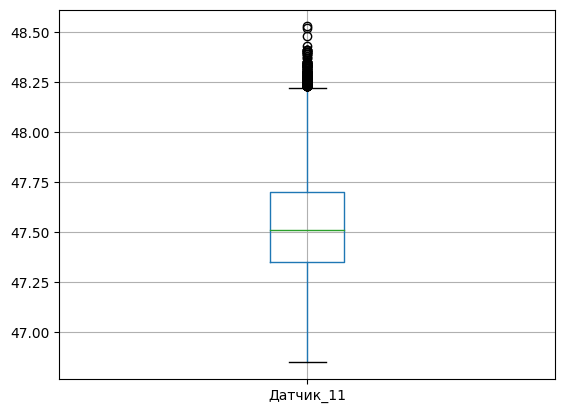

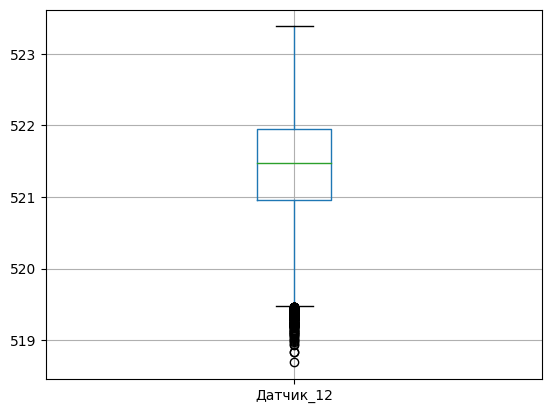

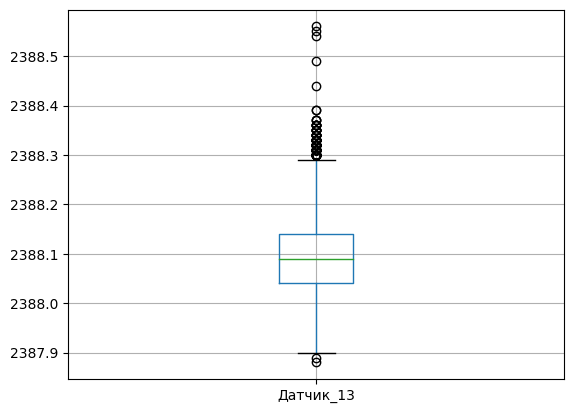

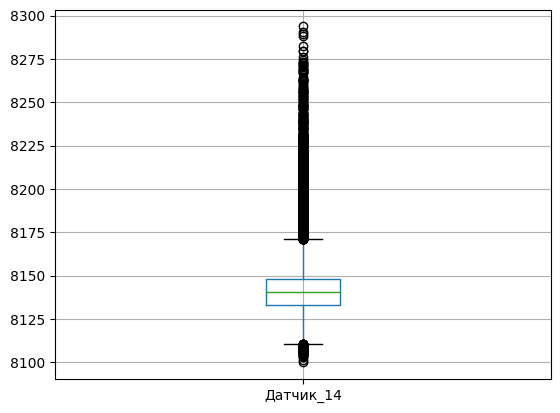

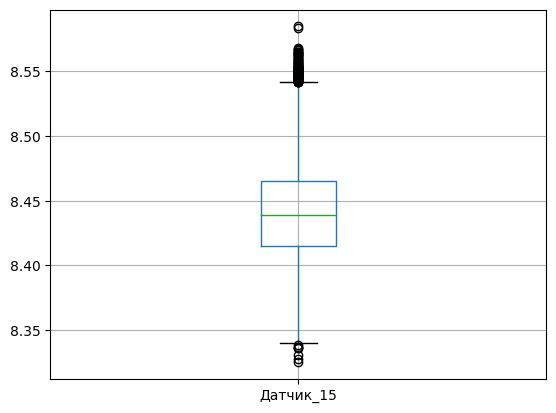

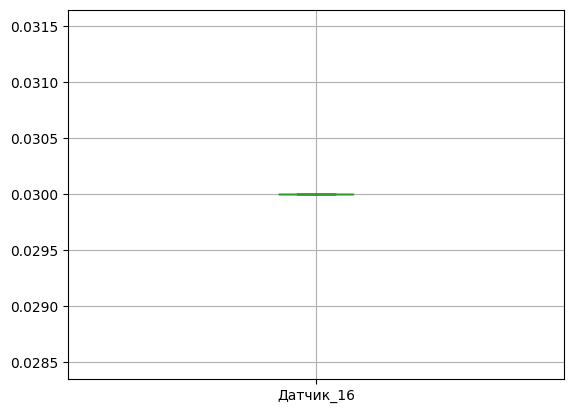

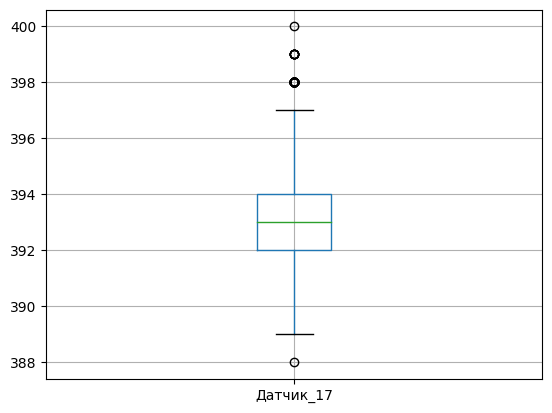

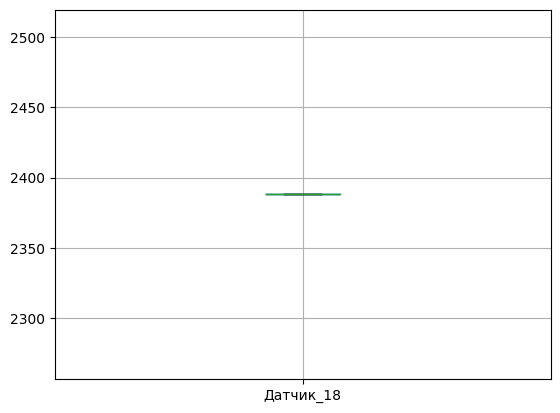

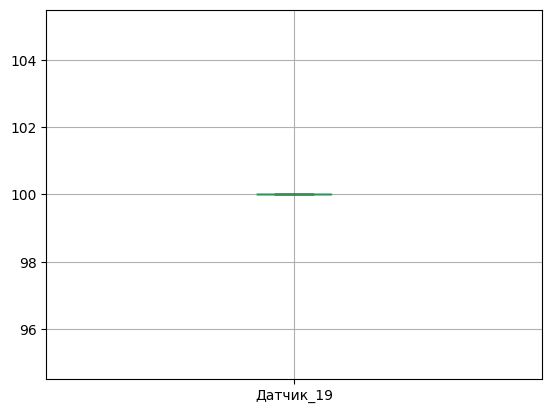

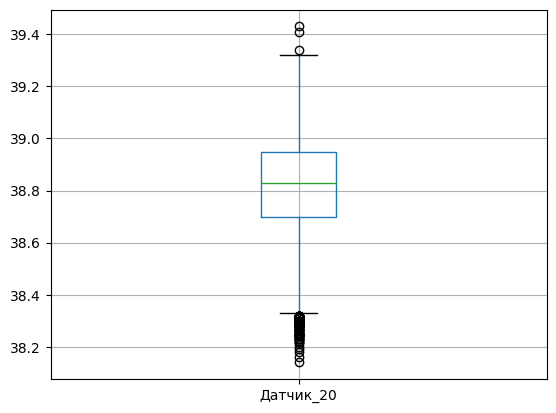

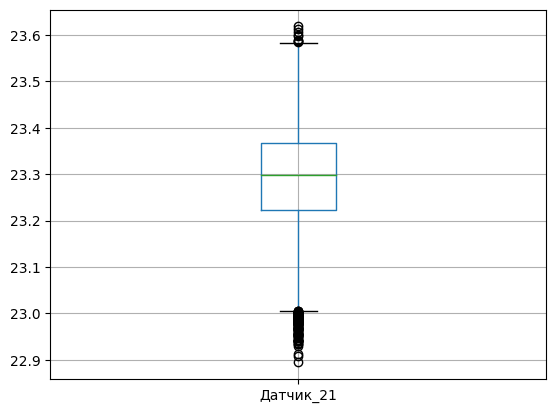

In [ ]:
# Строим диаграммы размаха для каждого признака
columns = pre_data.columns
for i in range(2, len(columns) - 1):
  plt.figure()
  pre_data.boxplot(columns[i])
  plt.show()

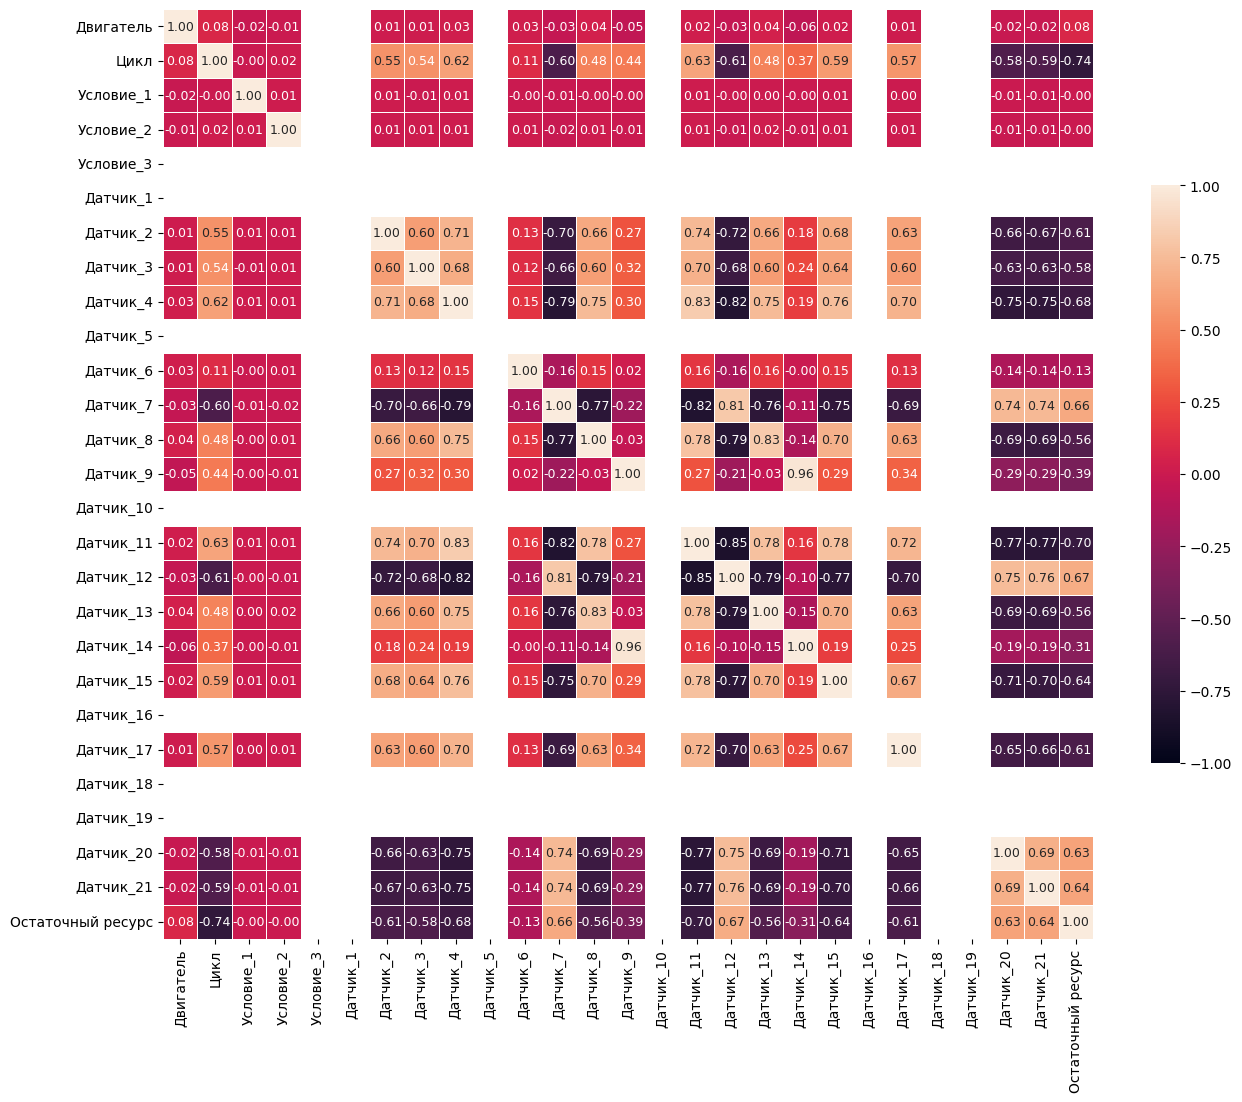

In [ ]:
# Строим матрицу корреляций для обучающих данных
plt.figure(figsize=(15, 15))
corr_matrix = pre_data.corr(numeric_only=True)
sns.heatmap(corr_matrix, vmin=-1, vmax=1,
            annot=True, fmt=".2f", annot_kws={"size": 9},
            linewidths=0.5, cbar_kws={"shrink": 0.5}, square=True)
plt.show()

In [ ]:
# Удаляем из обучающих данных неинформативные и высококоррелирующие признаки
pre_data.drop(columns=["Двигатель", "Условие_3", "Датчик_1", "Датчик_5",
                       "Датчик_9", "Датчик_10", "Датчик_16", "Датчик_18",
                       "Датчик_19"], inplace=True)

In [ ]:
# Просматриваем первые несколько строк предобработанных обучающих данных
pre_data.head()

,Цикл,Условие_1,Условие_2,Датчик_2,Датчик_3,Датчик_4,Датчик_6,Датчик_7,Датчик_8,Датчик_11,Датчик_12,Датчик_13,Датчик_14,Датчик_15,Датчик_17,Датчик_20,Датчик_21,Остаточный ресурс
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [ ]:
# Просматриваем первые несколько строк тестовых данных
test_data.head()

,Двигатель,Цикл,Условие_1,Условие_2,Условие_3,Датчик_1,Датчик_2,Датчик_3,Датчик_4,Датчик_5,...,Датчик_12,Датчик_13,Датчик_14,Датчик_15,Датчик_16,Датчик_17,Датчик_18,Датчик_19,Датчик_20,Датчик_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [ ]:
# Вычисляем максимальное количество полетных циклов для каждого авиадвигателя
# Оставляем в тестовых данных только строки с максимальным значением полетного цикла
pre_data_2 = test_data.copy(deep=True)
test_data_rul = pre_data_2.groupby(["Двигатель"])["Цикл"].max().reset_index()
test_data_rul.columns = ["Двигатель", "Максимальный остаточный ресурс"]
pre_data_2 = pre_data_2.merge(test_data_rul, how="left", on="Двигатель")
pre_data_2 = pre_data_2[(pre_data_2["Цикл"]==pre_data_2["Максимальный остаточный ресурс"])]
pre_data_2.drop(["Максимальный остаточный ресурс"], axis=1, inplace=True)

In [ ]:
# Просматриваем первые несколько строк тестовых данных
pre_data_2.head()

,Двигатель,Цикл,Условие_1,Условие_2,Условие_3,Датчик_1,Датчик_2,Датчик_3,Датчик_4,Датчик_5,...,Датчик_12,Датчик_13,Датчик_14,Датчик_15,Датчик_16,Датчик_17,Датчик_18,Датчик_19,Датчик_20,Датчик_21
30,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
79,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
205,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
311,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
409,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117


In [ ]:
# Формируем обучающую и тестовую выборки, а также целевую переменную для каждой выборки
y_train = pre_data["Остаточный ресурс"]
pre_data.drop(columns="Остаточный ресурс", inplace=True)
X_train = pre_data
y_test = rul_data.iloc[:, -1]
X_test = pre_data_2.drop(columns=["Двигатель", "Условие_3", "Датчик_1", "Датчик_5",
                       "Датчик_9", "Датчик_10", "Датчик_16", "Датчик_18",
                       "Датчик_19"])

In [ ]:
# Воспользуемся одним из методов масштабирования данных
scaler = RobustScaler()

In [ ]:
# Производим масштабирование обучающей и тестовой выборок
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Обучаем метод k-ближайших соседей
knr_base = KNeighborsRegressor()
knr_base.fit(X_train, y_train)

KNeighborsRegressor()

In [ ]:
# Выполняем прогнозирование и оцениваем качество модели
knr_y_pred = pd.Series(knr_base.predict(X_test))
knr_base_mae = round(mean_absolute_error(y_test, knr_y_pred), 2)
knr_base_rmse = round(sqrt(mean_squared_error(y_test, knr_y_pred)), 2)
knr_base_mape = round(mean_absolute_percentage_error(y_test, knr_y_pred), 2)
print(f"MAE базового KNR - {knr_base_mae}")
print(f"RMSE базового KNR - {knr_base_rmse}")
print(f"MAPE базового KNR - {knr_base_mape}")

MAE базового KNR - 21.97
RMSE базового KNR - 30.0
MAPE базового KNR - 0.35


In [ ]:
# Обучаем метод опорных векторов
svr_base = SVR()
svr_base.fit(X_train, y_train)

SVR()

In [ ]:
# Выполняем прогнозирование и оцениваем качество модели
svr_y_pred = pd.Series(svr_base.predict(X_test))
svr_base_mae = round(mean_absolute_error(y_test, svr_y_pred), 2)
svr_base_rmse = round(sqrt(mean_squared_error(y_test, svr_y_pred)), 2)
svr_base_mape = round(mean_absolute_percentage_error(y_test, svr_y_pred), 2)
print(f"MAE базового SVR - {svr_base_mae}")
print(f"RMSE базового SVR - {svr_base_rmse}")
print(f"MAPE базового SVR - {svr_base_mape}")

MAE базового SVR - 17.5
RMSE базового SVR - 23.75
MAPE базового SVR - 0.29


In [ ]:
# Обучаем метод случайного леса
rfr_base = RandomForestRegressor(random_state=25)
rfr_base.fit(X_train, y_train)

RandomForestRegressor(random_state=25)

In [ ]:
# Выполняем прогнозирование и оцениваем качество модели
rfr_y_pred = pd.Series(rfr_base.predict(X_test))
rfr_base_mae = round(mean_absolute_error(y_test, rfr_y_pred), 2)
rfr_base_rmse = round(sqrt(mean_squared_error(y_test, rfr_y_pred)), 2)
rfr_base_mape = round(mean_absolute_percentage_error(y_test, rfr_y_pred), 2)
print(f"MAE базового RFR - {rfr_base_mae}")
print(f"RMSE базового RFR - {rfr_base_rmse}")
print(f"MAPE базового RfR - {rfr_base_mape}")

MAE базового RFR - 19.93
RMSE базового RFR - 26.72
MAPE базового RfR - 0.32


In [ ]:
# Обучаем многослойный персептрон
mlpr_base = MLPRegressor(random_state=25)
mlpr_base.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(random_state=25)

In [ ]:
# Выполняем прогнозирование и оцениваем качество модели
mlpr_y_pred = pd.Series(mlpr_base.predict(X_test))
mlpr_base_mae = round(mean_absolute_error(y_test, mlpr_y_pred), 2)
mlpr_base_rmse = round(sqrt(mean_squared_error(y_test, mlpr_y_pred)), 2)
mlpr_base_mape = round(mean_absolute_percentage_error(y_test, mlpr_y_pred), 2)
print(f"MAE базового MLPR - {mlpr_base_mae}")
print(f"RMSE базового MLPR - {mlpr_base_rmse}")
print(f"MAPE базового MLPR - {mlpr_base_mape}")

MAE базового MLPR - 18.5
RMSE базового MLPR - 24.74
MAPE базового MLPR - 0.31


In [ ]:
# Обучаем градиентный бустинг над решающими деревьями
cbr_base = CatBoostRegressor(verbose=0, random_state=25)
cbr_base.fit(X_train, y_train)

In [ ]:
# Выполняем прогнозирование и оцениваем качество модели
cbr_y_pred = pd.Series(cbr_base.predict(X_test))
cbr_base_mae = round(mean_absolute_error(y_test, cbr_y_pred), 2)
cbr_base_rmse = round(sqrt(mean_squared_error(y_test, cbr_y_pred)), 2)
cbr_base_mape = round(mean_absolute_percentage_error(y_test, cbr_y_pred), 2)
print(f"MAE базового CBR - {cbr_base_mae}")
print(f"RMSE базового CBR - {cbr_base_rmse}")
print(f"MAPE базового CBR - {cbr_base_mape}")

MAE базового CBR - 19.88
RMSE базового CBR - 27.8
MAPE базового CBR - 0.31


In [ ]:
# Создаем сравнительную таблицу качества моделей
dict = {
    "ML_model": ["Базовый KNR", "Базовый SVR", "Базовый RFR", "Базовый MLPR", "Базовый CBR"],
    "MAE": [knr_base_mae, svr_base_mae, rfr_base_mae, mlpr_base_mae, cbr_base_mae],
    "RMSE": [knr_base_rmse, svr_base_rmse, rfr_base_rmse, mlpr_base_rmse, cbr_base_rmse],
    "MAPE": [knr_base_mape, svr_base_mape, rfr_base_mape, mlpr_base_mape, cbr_base_mape]
}
table_score = pd.DataFrame(dict)

In [ ]:
# Выводим таблицу на экран
table_score

,ML_model,MAE,RMSE,MAPE
0,Базовый KNR,21.97,30.00,0.35
1,Базовый SVR,17.50,23.75,0.29
2,Базовый RFR,19.93,26.72,0.32
3,Базовый MLPR,18.50,24.74,0.31
4,Базовый CBR,19.88,27.80,0.31


In [ ]:
# Создаем сетку гиперпараметров и выполняем поиск лучшей комбинации
# Обучаем метод k-ближайших соседей
param_grid = {
    "n_neighbors": range(3, 21),
    "weights": ["uniform", "distance"],
    "metric": ["manhattan", "euclidean", "minkowski"]
}
knr_tuned = RandomizedSearchCV(KNeighborsRegressor(), param_grid, random_state=25)
knr_tuned.fit(X_train, y_train)

RandomizedSearchCV(estimator=KNeighborsRegressor(),
                   param_distributions={'metric': ['manhattan', 'euclidean',
                                                   'minkowski'],
                                        'n_neighbors': range(3, 21),
                                        'weights': ['uniform', 'distance']},
                   random_state=25)

In [ ]:
# Выводим лучшие гиперпараметры
# Выполняем прогнозирование и оцениваем качество модели
knr_tuned_y_pred = pd.Series(knr_tuned.predict(X_test))
knr_tuned_mae = round(mean_absolute_error(y_test, knr_tuned_y_pred), 2)
knr_tuned_rmse = round(sqrt(mean_squared_error(y_test, knr_tuned_y_pred)), 2)
knr_tuned_mape = round(mean_absolute_percentage_error(y_test, knr_tuned_y_pred), 2)
print("Лучшие гиперпараметры:", knr_tuned.best_params_)
print(f"MAE оптимизированного KNR - {knr_tuned_mae}")
print(f"RMSE оптимизированного KNR - {knr_tuned_rmse}")
print(f"MAPE оптимизированного KNR - {knr_tuned_mape}")

Лучшие гиперпараметры: {'weights': 'distance', 'n_neighbors': 20, 'metric': 'manhattan'}
MAE оптимизированного KNR - 21.24
RMSE оптимизированного KNR - 29.03
MAPE оптимизированного KNR - 0.34


In [ ]:
# Создаем сетку гиперпараметров и выполняем поиск лучшей комбинации
# Обучаем метод опорных векторов
param_grid = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.1, 0.25, 0.5, 0.75, 1],
    "gamma": ["scale", "auto"]
}
svr_tuned = RandomizedSearchCV(SVR(), param_grid, random_state=25)
svr_tuned.fit(X_train, y_train)

RandomizedSearchCV(estimator=SVR(),
                   param_distributions={'C': [0.1, 0.25, 0.5, 0.75, 1],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=25)

In [ ]:
# Выводим лучшие гиперпараметры
# Выполняем прогнозирование и оцениваем качество модели
svr_tuned_y_pred = pd.Series(svr_tuned.predict(X_test))
svr_tuned_mae = round(mean_absolute_error(y_test, svr_tuned_y_pred), 2)
svr_tuned_rmse = round(sqrt(mean_squared_error(y_test, svr_tuned_y_pred)), 2)
svr_tuned_mape = round(mean_absolute_percentage_error(y_test, svr_tuned_y_pred), 2)
print("Лучшие гиперпараметры:", svr_tuned.best_params_)
print(f"MAE оптимизированного SVR - {svr_tuned_mae}")
print(f"RMSE оптимизированного SVR - {svr_tuned_rmse}")
print(f"MAPE оптимизированного SVR - {svr_tuned_mape}")

Лучшие гиперпараметры: {'kernel': 'rbf', 'gamma': 'auto', 'C': 0.5}
MAE оптимизированного SVR - 17.63
RMSE оптимизированного SVR - 24.39
MAPE оптимизированного SVR - 0.3


In [ ]:
# Создаем сетку гиперпараметров и выполняем поиск лучшей комбинации
# Обучаем метод случайного леса
param_grid = {
    "n_estimators": [50, 150, 300, 450, 600],
    "max_depth": [5, 10, 15, 20],
    "bootstrap": [True, False]
}
rfr_tuned = RandomizedSearchCV(RandomForestRegressor(random_state=25), param_grid, random_state=25)
rfr_tuned.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(random_state=25),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20],
                                        'n_estimators': [50, 150, 300, 450,
                                                         600]},
                   random_state=25)

In [ ]:
# Выводим лучшие гиперпараметры
# Выполняем прогнозирование и оцениваем качество модели
rfr_tuned_y_pred = pd.Series(rfr_tuned.predict(X_test))
rfr_tuned_mae = round(mean_absolute_error(y_test, rfr_tuned_y_pred), 2)
rfr_tuned_rmse = round(sqrt(mean_squared_error(y_test, rfr_tuned_y_pred)), 2)
rfr_tuned_mape = round(mean_absolute_percentage_error(y_test, rfr_tuned_y_pred), 2)
print("Лучшие гиперпараметры:", rfr_tuned.best_params_)
print(f"MAE оптимизированного RFR - {rfr_tuned_mae}")
print(f"RMSE оптимизированного RFR - {rfr_tuned_rmse}")
print(f"MAPE оптимизированного RFR - {rfr_tuned_mape}")

Лучшие гиперпараметры: {'n_estimators': 150, 'max_depth': 10, 'bootstrap': True}
MAE оптимизированного RFR - 19.26
RMSE оптимизированного RFR - 25.38
MAPE оптимизированного RFR - 0.33


In [ ]:
# Создаем сетку гиперпараметров и выполняем поиск лучшей комбинации
# Обучаем многослойный персептрон
param_grid = {
    "hidden_layer_sizes": [(128,), (256,), (64, 128), (128, 256)],
    "activation": ["identity", "logistic", "tanh", "relu"],
    "max_iter": [150, 300, 450, 600],
    "shuffle": [True, False]
}
mlpr_tuned = RandomizedSearchCV(MLPRegressor(random_state=25, verbose=False), param_grid, random_state=25)
mlpr_tuned.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

RandomizedSearchCV(estimator=MLPRegressor(random_state=25),
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'hidden_layer_sizes': [(128,), (256,),
                                                               (64, 128),
                                                               (128, 256)],
                                        'max_iter': [150, 300, 450, 600],
                                        'shuffle': [True, False]},
                   random_state=25)

In [ ]:
# Выводим лучшие гиперпараметры
# Выполняем прогнозирование и оцениваем качество модели
mlpr_tuned_y_pred = pd.Series(mlpr_tuned.predict(X_test))
mlpr_tuned_mae = round(mean_absolute_error(y_test, mlpr_tuned_y_pred), 2)
mlpr_tuned_rmse = round(sqrt(mean_squared_error(y_test, mlpr_tuned_y_pred)), 2)
mlpr_tuned_mape = round(mean_absolute_percentage_error(y_test, mlpr_tuned_y_pred), 2)
print("Лучшие гиперпараметры:", mlpr_tuned.best_params_)
print(f"MAE оптимизированного MLPR - {mlpr_tuned_mae}")
print(f"RMSE оптимизированного MLPR - {mlpr_tuned_rmse}")
print(f"MAPE оптимизированного MLPR - {mlpr_tuned_mape}")

Лучшие гиперпараметры: {'shuffle': True, 'max_iter': 300, 'hidden_layer_sizes': (128,), 'activation': 'logistic'}
MAE оптимизированного MLPR - 18.85
RMSE оптимизированного MLPR - 25.41
MAPE оптимизированного MLPR - 0.33


In [ ]:
# Создаем сетку гиперпараметров и выполняем поиск лучшей комбинации
# Обучаем градиентный бустинг над решающими деревьями
param_grid = {
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 5, 10],
    "n_estimators": [100, 200, 400, 800],
    "l2_leaf_reg": [1, 3, 5, 7, 9]
}
cbr_tuned = RandomizedSearchCV(CatBoostRegressor(verbose=0, random_state=25), param_grid, random_state=25)
cbr_tuned.fit(X_train, y_train)

RandomizedSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7b31c339c820>,
                   param_distributions={'l2_leaf_reg': [1, 3, 5, 7, 9],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 5, 10],
                                        'n_estimators': [100, 200, 400, 800]},
                   random_state=25)

In [ ]:
# Выводим лучшие гиперпараметры
# Выполняем прогнозирование и оцениваем качество модели
br_tuned_y_pred = pd.Series(cbr_tuned.predict(X_test))
cbr_tuned_mae = round(mean_absolute_error(y_test, cbr_tuned_y_pred), 2)
cbr_tuned_rmse = round(sqrt(mean_squared_error(y_test, cbr_tuned_y_pred)), 2)
cbr_tuned_mape = round(mean_absolute_percentage_error(y_test, cbr_tuned_y_pred), 2)
print("Лучшие гиперпараметры:", cbr_tuned.best_params_)
print(f"MAE оптимизированного RFR - {cbr_tuned_mae}")
print(f"RMSE оптимизированного RFR - {cbr_tuned_rmse}")
print(f"MAPE оптимизированного RFR - {cbr_tuned_mape}")

Лучшие гиперпараметры: {'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.01, 'l2_leaf_reg': 3}
MAE оптимизированного RFR - 18.01
RMSE оптимизированного RFR - 24.41
MAPE оптимизированного RFR - 0.31


In [ ]:
# Создаем сравнительную таблицу качества оптимизированных моделей
tuned_dict = {
    "ML_model": ["Оптимизированный KNR", "Оптимизированный SVR", "Оптимизированный RFR",
                 "Оптимизированный MLPR", "Оптимизированный CBR"],
    "MAE": [knr_tuned_mae, svr_tuned_mae, rfr_tuned_mae, mlpr_tuned_mae, cbr_tuned_mae],
    "RMSE": [knr_tuned_rmse, svr_tuned_rmse, rfr_tuned_rmse, mlpr_tuned_rmse, cbr_tuned_rmse],
    "MAPE": [knr_tuned_mape, svr_tuned_mape, rfr_tuned_mape, mlpr_tuned_mape, cbr_tuned_mape]
}
tuned_table_score = pd.DataFrame(tuned_dict)

In [ ]:
# Выводим таблицу на экран
tuned_table_score

,ML_model,MAE,RMSE,MAPE
0,Оптимизированный KNR,21.24,29.03,0.34
1,Оптимизированный SVR,17.63,24.39,0.30
2,Оптимизированный RFR,19.26,25.38,0.33
3,Оптимизированный MLPR,18.85,25.41,0.33
4,Оптимизированный CBR,18.01,24.41,0.31


In [ ]:
# Выполняем построение нейронной сети
neuronet = keras.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=(1,X_train.shape[1])),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(50, return_sequences=True, activation="tanh"),
    keras.layers.Dropout(0.5),
    keras.layers.LSTM(10, return_sequences=True, activation="tanh"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(1)
])

In [ ]:
# Определяем конфигурацию обучения
neuronet.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# Выводим на экран архитектуру и параметры нейронной сети
neuronet.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 1, 100)            47200     
                                                                 
 batch_normalization_12 (Ba  (None, 1, 100)            400       
 tchNormalization)                                               
                                                                 
 lstm_37 (LSTM)              (None, 1, 50)             30200     
                                                                 
 dropout_24 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_38 (LSTM)              (None, 1, 10)             2440      
                                                                 
 dropout_25 (Dropout)        (None, 1, 10)             0         
                                                     

In [ ]:
# Изменяем форму обучающей и тестовой выборки
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
# Обучаем построенную нейронную сеть
history = neuronet.fit(X_train_reshaped, y_train, epochs=45, batch_size=512)

Epoch 1/45
41/41 [==============================] - 7s 21ms/step - loss: 16198.6699
Epoch 2/45
41/41 [==============================] - 1s 34ms/step - loss: 14975.6592
Epoch 3/45
41/41 [==============================] - 1s 33ms/step - loss: 12376.6338
Epoch 4/45
41/41 [==============================] - 1s 28ms/step - loss: 9499.4678
Epoch 5/45
41/41 [==============================] - 1s 20ms/step - loss: 7045.7964
Epoch 6/45
41/41 [==============================] - 1s 20ms/step - loss: 5224.3140
Epoch 7/45
41/41 [==============================] - 1s 21ms/step - loss: 3998.3701
Epoch 8/45
41/41 [==============================] - 1s 20ms/step - loss: 3356.0786
Epoch 9/45
41/41 [==============================] - 1s 19ms/step - loss: 3003.0396
Epoch 10/45
41/41 [==============================] - 1s 20ms/step - loss: 2753.5083
Epoch 11/45
41/41 [==============================] - 1s 20ms/step - loss: 2596.9324
Epoch 12/45
41/41 [==============================] - 1s 20ms/step - loss: 2512.704

In [ ]:
# Выполняем прогнозирование и оцениваем качество модели
y_predictions = neuronet.predict(X_test_reshaped)[:,0][:,0]
neuronet_mae = round(mean_absolute_error(y_test, y_predictions), 2)
neuronet_rmse = round(sqrt(mean_squared_error(y_test, y_predictions)), 2)
neuronet_mape = round(mean_absolute_percentage_error(y_test, y_predictions), 2)
print(f"MAE нейронной сети - {neuronet_mae}")
print(f"RMSE нейронной сети - {neuronet_rmse}")
print(f"MAPE нейронной сети - {neuronet_mape}")

4/4 [==============================] - 2s 6ms/step
MAE нейронной сети - 16.76
RMSE нейронной сети - 22.44
MAPE нейронной сети - 0.3


In [ ]:
# Выполняем сохранение нейронной сети в файл формата .h5
neuronet.save("Neuronet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Выполняем сохранение метода масштабирования данных в файл формата .joblib
joblib.dump(scaler, "Scaler.joblib")

['Scaler.joblib']